In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
import warnings
warnings.filterwarnings("ignore" )

In [23]:
#Let us Generate 100,000 Random Uniform coordinates between 0 and 10000
x = np.random.uniform(0,10000,100000)
y = np.random.uniform(0,10000,100000)
uniformpoints=np.column_stack((x,y))

In [24]:

# Randomly Assign 50,000 points as Immune cells and remaining as Tumor Cells
row_i = np.random.choice(uniformpoints.shape[0],50000)
Immunepoints=uniformpoints[row_i, :]
Tumorpoints=uniformpoints[-row_i, :]

In [25]:
# Function to make bounding boxes
def makeboxes(points,size):
        # Find min,max of both x and y coordinates
        a = np.zeros((2,2))
        a[:,0],a[:,1] = np.min(points, axis=0),np.max(points, axis=0)
        xmin,xmax,ymin,ymax=a[0,0],a[0,1],a[1,0],a[1,1]
        # Calculating number of boxes that can fit in given square
        xinterval,yinterval=xmax-xmin,ymax-ymin
        n_xboxes,n_yboxes=np.floor(xinterval/size),np.floor(yinterval/size)
        # Adjusting xmax and ymax to fit perfect boxes, here you will loose area to the right
        # you can also choose to loose area to left by adjusting xmin and xmax 
        n_xmax,n_ymax=xmin+n_xboxes*size,ymin+n_yboxes*size
        # making x and y points for the square boundaries and making intervals
        xpoints = np.linspace(xmin, n_xmax, num=n_xboxes+1)
        ypoints=np.linspace(ymin,n_ymax, num=n_yboxes+1)
        xintervals=np.array([xpoints[:-1], xpoints[1:]]).transpose()
        yintervals=np.array([ypoints[:-1],ypoints[1:]]).transpose()
        # Making a grid and finally an array of boxes
        grid_boxes=[]
        for f in range(0,len(yintervals)):
            for k in range(0,len(xintervals)):
                grid_boxes.append(np.column_stack([xintervals[k],yintervals[f]]).flatten())
        return grid_boxes

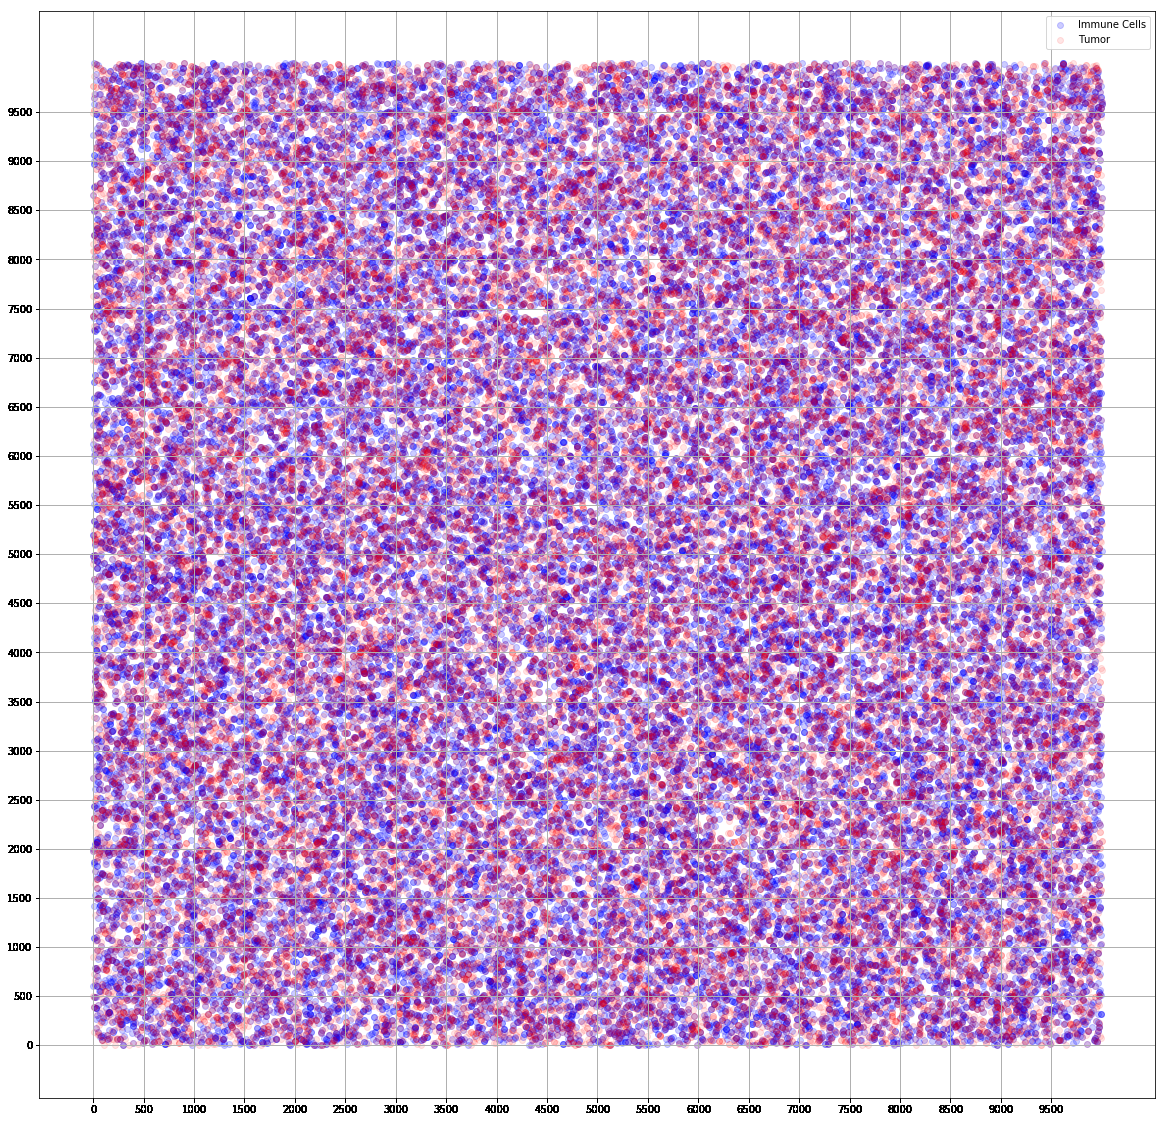

In [26]:
# Let us make Bounding Boxes from uniform points and plot Immune and Tumor cells
boxes=makeboxes(uniformpoints,500)
xcors=np.concatenate([np.array(boxes)[:,0],np.array(boxes)[:,2]])
ycors=np.concatenate([np.array(boxes)[:,1],np.array(boxes)[:,3]])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(xcors)
ax.set_yticks(ycors)
ax.grid()
I=plt.scatter(Immunepoints[:,0],Immunepoints[:,1],color='b',alpha=0.2)
T=plt.scatter(Tumorpoints[:,0],Tumorpoints[:,1],color='r',alpha=0.1)
plt.legend((I,T), ('Immune Cells', 'Tumor'),scatterpoints=1,loc='upper right',fontsize=10)

In [27]:
# Helper Function to count the points inside each bounding box
def in_bounding_box(points,box):
        min_x=box[0]
        max_x=box[2]
        min_y=box[1]
        max_y=box[3]
        bound_x = np.logical_and(points[:, 0] > min_x, points[:, 0] < max_x)
        bound_y = np.logical_and(points[:, 1] > min_y, points[:, 1] < max_y)
        bb_filter = np.logical_and(bound_x, bound_y)
        return len(points[bb_filter])

In [28]:
# Calculate MH index
def calculate_MHindex(Immunepoints,Tumorpoints,boxes):
        # Let's make a dataframe of Immune and Tunorpoints 
        immune_list=[]
        tumor_list=[]
        for f in range(0,len(boxes)):
            immune_list.append(in_bounding_box(Immunepoints,boxes[f]))
            tumor_list.append(in_bounding_box(Tumorpoints,boxes[f]))
        MH_df=pd.concat([pd.DataFrame(immune_list),pd.DataFrame(tumor_list)],axis=1)
        MH_df.columns=['immune','tumor']
        # Make a dataframe with all required columns for the calculation of MH
        def calculate_MH(MH_df):
            Immune_total=MH_df['immune'].sum()
            tumor_total=MH_df['tumor'].sum()
            prop_IC=MH_df['immune']/(Immune_total)
            prop_TC=MH_df['tumor']/(tumor_total)
            product_ICTC=prop_IC*prop_TC
            prop_IC_square=prop_IC*prop_IC
            prop_TC_square=prop_TC*prop_TC
            cal_cols=pd.concat([prop_IC,prop_TC,product_ICTC,prop_IC_square,prop_TC_square],axis=1).fillna(0)
            cal_cols.columns=['prop_IC','prop_TC','product_ICTC','prop_IC_square','prop_TC_square']
            return cal_cols
        # Calculate MH
        sub=calculate_MH(MH_df)['product_ICTC']>0
        subset=calculate_MH(MH_df)[sub]
        MH=2*subset['product_ICTC'].sum()/(subset['prop_IC_square'].sum()+subset['prop_TC_square'].sum())
        result=MH,subset['prop_IC'].mean(),subset['prop_TC'].mean(),len(subset)
        result_df=pd.DataFrame(list(result)).transpose()
        result_df.columns=['MHindex_ICTC','Avg_ICprop','Avg_TCprop','Numcells_ICTC']
        return result_df

In [29]:
calculate_MHindex(Immunepoints,Tumorpoints,boxes)

,MHindex_ICTC,Avg_ICprop,Avg_TCprop,Numcells_ICTC
0,0.992502,0.00277,0.00277,361.0
